In [2]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt



2023-11-11 14:43:21.956087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 14:43:21.956119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 14:43:21.956181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 14:43:21.967820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-11-11 14:43:36.284749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 14:43:36.290956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 14:43:36.291303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

RuntimeError: Bad StatusOr access: INTERNAL: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 3169189888

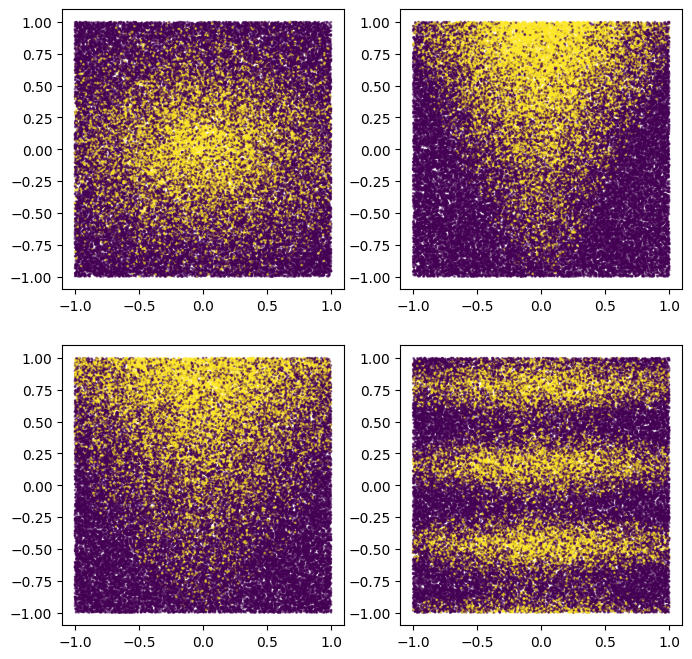

In [3]:
def make_dataset(num_examples, num_features, seed=1234):
  np.random.seed(seed)
  features = np.random.uniform(-1, 1, size=(num_examples, num_features))
  noise = np.random.uniform(size=(num_examples))

  left_side = np.sqrt(
      np.sum(np.multiply(np.square(features[:, 0:2]), [1, 2]), axis=1))
  right_side = features[:, 2] * 0.7 + np.sin(
      features[:, 3] * 10) * 0.5 + noise * 0.0 + 0.5

  labels = left_side <= right_side
  return features, labels.astype(int)
make_dataset(num_examples=5, num_features=4)
plot_features, plot_label = make_dataset(num_examples=50000, num_features=4)

plt.rcParams["figure.figsize"] = [8, 8]
common_args = dict(c=plot_label, s=1.0, alpha=0.5)

plt.subplot(2, 2, 1)
plt.scatter(plot_features[:, 0], plot_features[:, 1], **common_args)

plt.subplot(2, 2, 2)
plt.scatter(plot_features[:, 1], plot_features[:, 2], **common_args)

plt.subplot(2, 2, 3)
plt.scatter(plot_features[:, 0], plot_features[:, 2], **common_args)

plt.subplot(2, 2, 4)
plt.scatter(plot_features[:, 0], plot_features[:, 3], **common_args)

def make_tf_dataset(batch_size=64, **args):
  features, labels = make_dataset(**args)
  return tf.data.Dataset.from_tensor_slices(
      (features, labels)).batch(batch_size)


num_features = 10

train_dataset = make_tf_dataset(
    num_examples=2500, num_features=num_features, batch_size=100, seed=1234)
test_dataset = make_tf_dataset(
    num_examples=10000, num_features=num_features, batch_size=100, seed=5678)

# Input features.
raw_features = tf.keras.layers.Input(shape=(num_features,))




In [5]:
raw_features.shape

TensorShape([None, 10])

Use /tmp/tmp6aw7vwmk as temporary training directory


Use /tmp/tmp2_jmwdi0 as temporary training directory


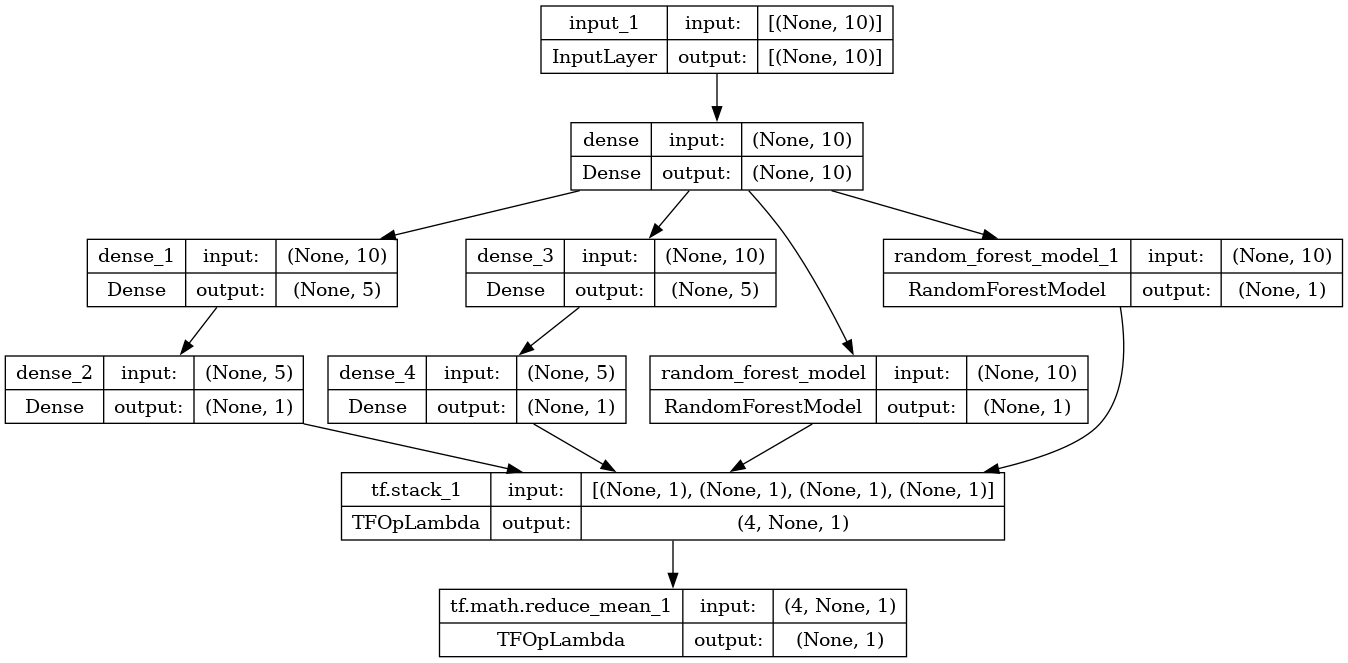

In [ ]:
# Stage 1
# =======

# Common learnable pre-processing
preprocessor = tf.keras.layers.Dense(10, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)

# Stage 2
# =======

# Model #1: NN
m1_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m1_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m1_z1)

# Model #2: NN
m2_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m2_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m2_z1)


# Model #3: DF
model_3 = tfdf.keras.RandomForestModel(num_trees=1000, random_seed=1234)
m3_pred = model_3(preprocess_features)

# Model #4: DF
model_4 = tfdf.keras.RandomForestModel(
    num_trees=1000,
    #split_axis="SPARSE_OBLIQUE", # Uncomment this line to increase the quality of this model
    random_seed=4567)
m4_pred = model_4(preprocess_features)

# Since TF-DF uses deterministic learning algorithms, you should set the model's
# training seed to different values otherwise both
# `tfdf.keras.RandomForestModel` will be exactly the same.

# Stage 3
# =======

mean_nn_only = tf.reduce_mean(tf.stack([m1_pred, m2_pred], axis=0), axis=0)


# Keras Models
# ============

ensemble_nn_only = tf.keras.models.Model(raw_features, mean_nn_only)

from keras.utils import plot_model

plot_model(ensemble_nn_only, to_file="/tmp/model.png", show_shapes=True)

In [6]:
ensemble_nn_only.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 10)                   110       ['input_1[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 5)                    55        ['dense_5[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 5)                    55        ['dense_5[0][0]']             
                                                                                            